# Unsupervised learning - PCA and clustering notebook for the US Arrests Kaggle challenge

https://www.kaggle.com/datasets/kurohana/usarrets

#### First explore the dataset
This data contains statistics of arrests per 100,000 residents for assault, murder and rape in each of the 50 US states in 1973. The percentage of the population living in urban areas was also given.<br>


In [1]:
# Import packages and dataset

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import pearsonr
%matplotlib inline

df = pd.read_csv("UsArrests.csv",index_col='City')
df.head()


,Murder,Assault,UrbanPop,Rape
City,,,,
Alabama,13.2,236,58,21.2
Alaska,10.0,263,48,44.5
Arizona,8.1,294,80,31.0
Arkansas,8.8,190,50,19.5
California,9.0,276,91,40.6


In [2]:
print('Number of cases: {} Number of features: {}'.format(df.shape[0],df.shape[1]))

Number of cases: 50 Number of features: 4


The dataset shows 4 variables and 50 rows. These rows are based on 1 state in the US therefore, there are no duplicates in the dataset.
Summarising the statistical properties of the data



In [3]:
#To set the decimal precision:
pd.set_option('display.float_format', lambda x: '%.2f' % x) 

#The describe function give us insight into the statistical properties of the columns
stats = df.describe()
selected_stats = stats.loc[["mean","std","min","max"]].transpose() #select relevant rows
selected_stats

,mean,std,min,max
Murder,7.79,4.36,0.80,17.40
Assault,170.76,83.34,45.00,337.00
UrbanPop,65.54,14.47,32.00,91.00
Rape,21.23,9.37,7.30,46.00


Check for missing values

In [4]:
# Count missing values
missing = df.isnull().sum()
relevant_missing = pd.DataFrame(missing, columns=["missing"])
relevant_missing

# Looks like there are no missing values in the dataset for each variable.

,missing
Murder,0
Assault,0
UrbanPop,0
Rape,0


In [5]:
df.info()

# All data is in the correct format as categorical data cannot be analysed using PCA.

<class 'pandas.core.frame.DataFrame'>
Index: 50 entries, Alabama to Wyoming
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Murder    50 non-null     float64
 1   Assault   50 non-null     int64  
 2   UrbanPop  50 non-null     int64  
 3   Rape      50 non-null     float64
dtypes: float64(2), int64(2)
memory usage: 2.0+ KB


Let's look at the distribution of the dataset

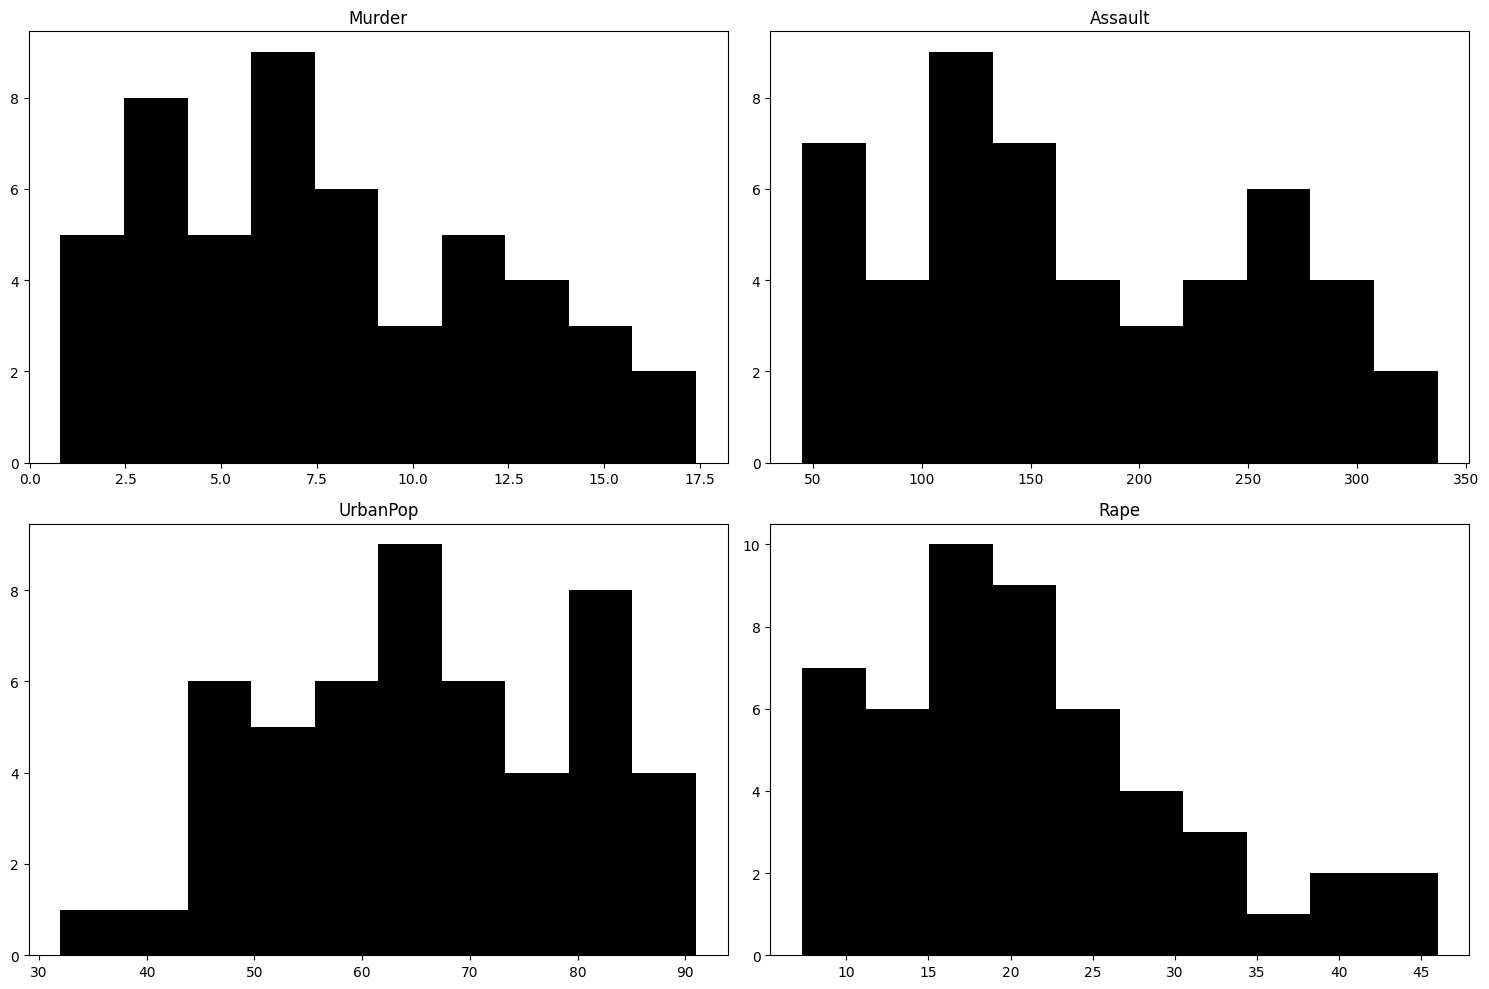

In [6]:
# Plot histograms
histograms = df.hist(color='black', grid=False, figsize=(15, 10)) #This can also be done for each column individually by calling hist on that column
plt.tight_layout()
plt.show()

The distribution of the dataset does not follow a bell shape. This means, for example, the number of rape cases is skewed to the left. In order to ensure the data can be compared across all variables, it needs to be scaled before PCA.

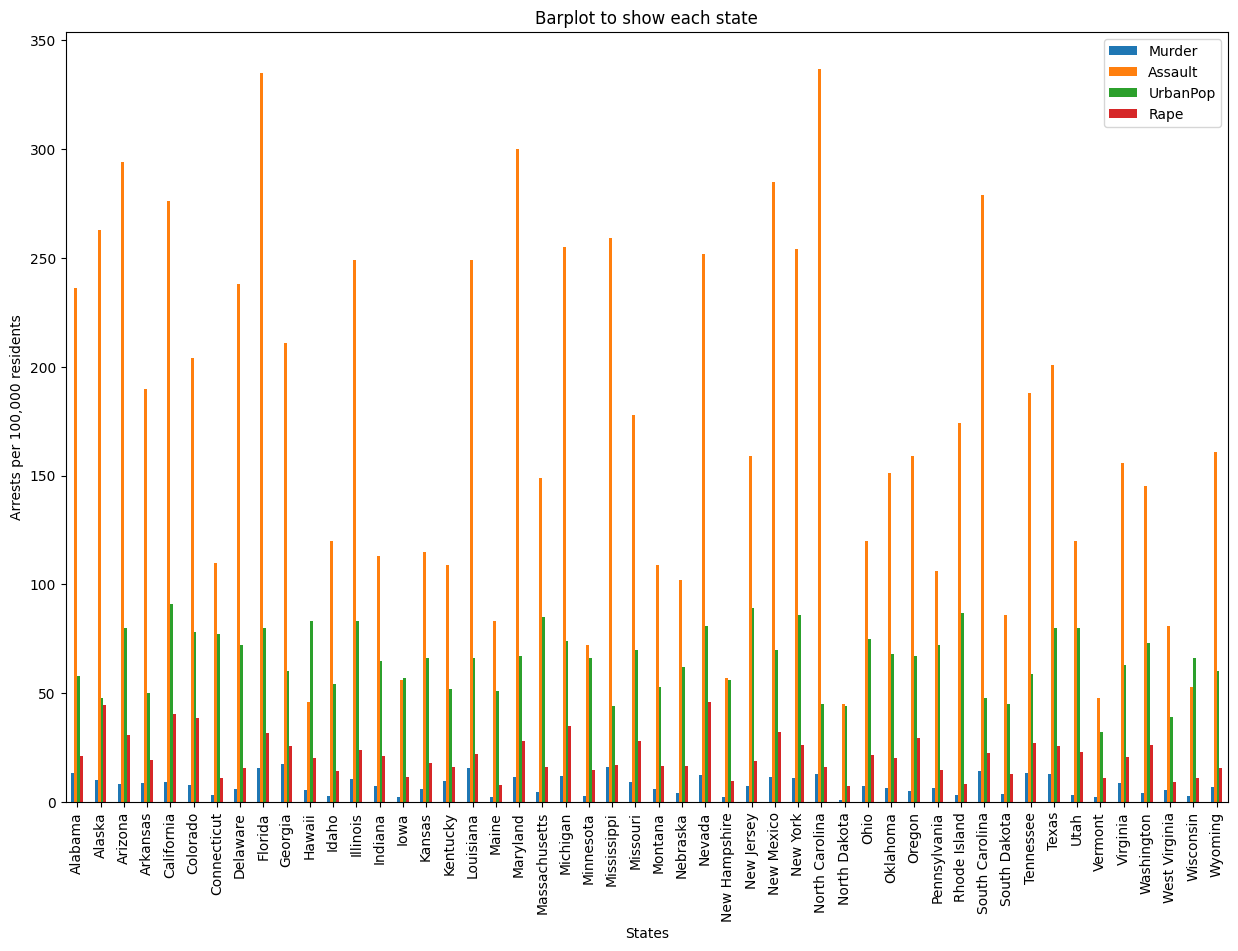

In [7]:
# A bar chart was plotted to compare the variables against each other.
bars = df.plot.bar(grid=False, figsize=(15, 10), xlabel = "States", ylabel = "Arrests per 100,000 residents", title = "Barplot to show each state") #This can also be done for each column individually by calling hist on that column
plt.show()

Interestingly, Hawaii and Winsconson are the only states that consists of larger urban populations compared to arrests of murder, assault and rape. 
<br>
North Carolina and Florida have the highest number of arrests for assault, whereas the lowest is Hawaii and North Dakota.
<br>
Georgia and Mississippi have the highest number of arrests for murder whereas, North Dakota has the lowest.
<br>
Nevada has the highest number of arrests for rape whereas, North Dakota is the lowest.
<br>
California and New Jersey has the highest urban population whereas, Vermont is the lowest.
<br>
Based on this information, it looks like North Dakota is the safest place to live in the US.



It would be intetresting to see the distribution of data and also the correlations between variables. 

This code was found here:
https://stackoverflow.com/questions/50832204/show-correlation-values-in-pairplot-using-seaborn-in-python

In [8]:
# A function was created to define the correlation using Pearson's correlation co-efficient and where to plot it

def corrfunc(x, y, hue=None, ax=None, **kws):
    """Plot the correlation coefficient in the top left hand corner of a plot."""
    r, _ = pearsonr(x, y)
    ax = ax or plt.gca()
    ax.annotate(f'ρ = {r:.2f}', xy=(.1, .9), xycoords=ax.transAxes)

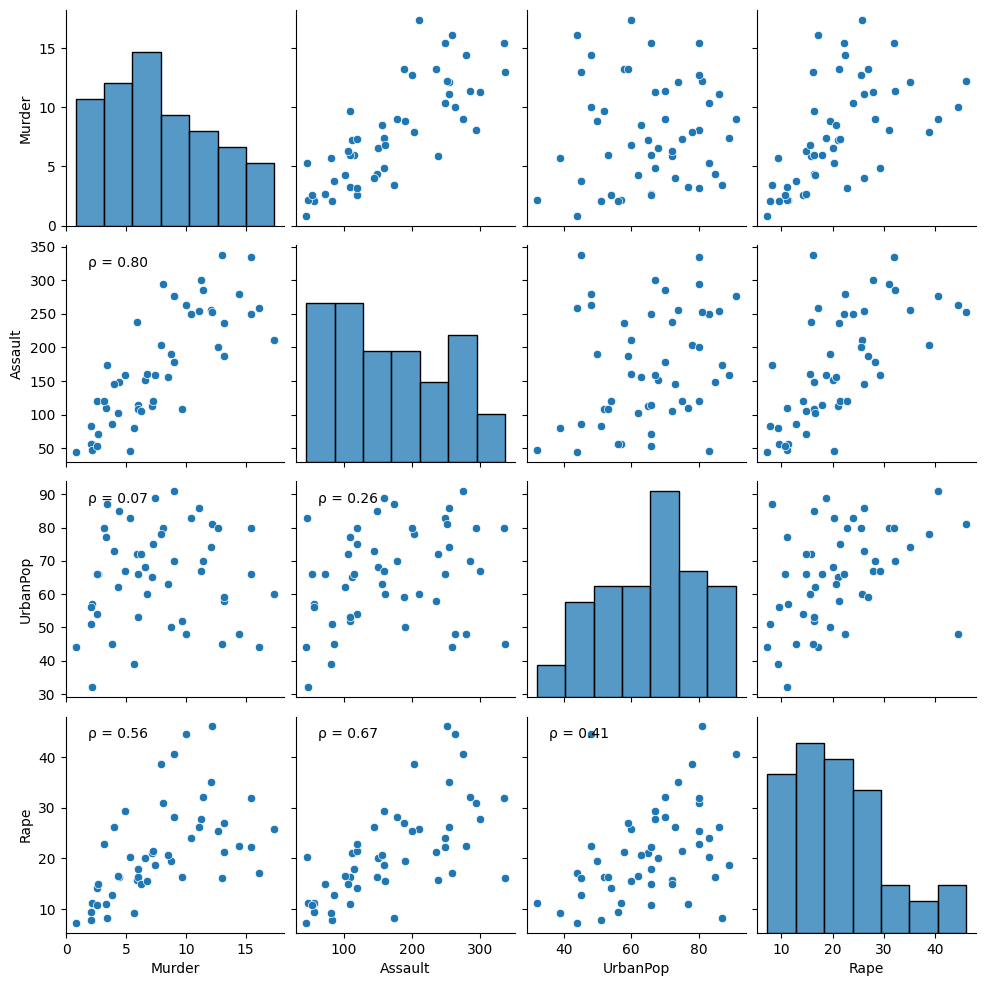

In [9]:
g = sns.pairplot(df)
g.map_lower(corrfunc)
plt.show()

Based on the pairplot above, there is a strong positive correlation between assault and murder (p = 0.80). Followed by rape against murder (p = 0.56) and assault (p = 0.67). <br>
Interestingly, as the urban population increases, so does the rape cases but not so much assault and murder.

In [10]:
# Create summary table
frames = [relevant_missing,selected_stats]
summary = pd.concat(frames, axis=1)
summary.rename(columns = {0:"missing"}, inplace = True)
summary.to_csv('summary.csv', index=True) 
summary


,missing,mean,std,min,max
Murder,0,7.79,4.36,0.80,17.40
Assault,0,170.76,83.34,45.00,337.00
UrbanPop,0,65.54,14.47,32.00,91.00
Rape,0,21.23,9.37,7.30,46.00


Looking at the summary table, most of the results have quite a high standard deviation meaning a large range. This is an indicator to scale the data before PCA analysis.

## Boxplot of the variables
A boxplot was created just to understand the spread of the data.<br>
It looks like there is quite a bit of variation especially for assault. This will be standardised before plotting the PCA. 

<AxesSubplot: >

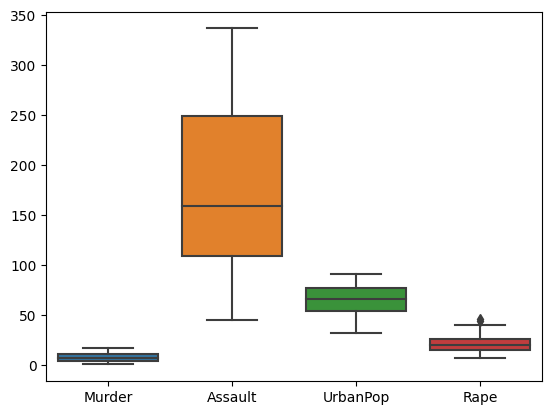

In [11]:
sns.boxplot(df)

## Correlation analysis

To view correlations based on a heatmap, seaborn was used. Pandas offers a highly useful function, ``corr``, which allows us to compute correlations between the different columns. The standard correlation coefficient is the Pearson coefficient. It returns a matrix of values. It is often useful to visualise these as a plot. <br>

This dataset doesn't show any negative correlations as the scaling used is not negative. This means urban population and murder have no correlation as it's values approach zero. Assault and murder have a strong positive correlation as discussed above.

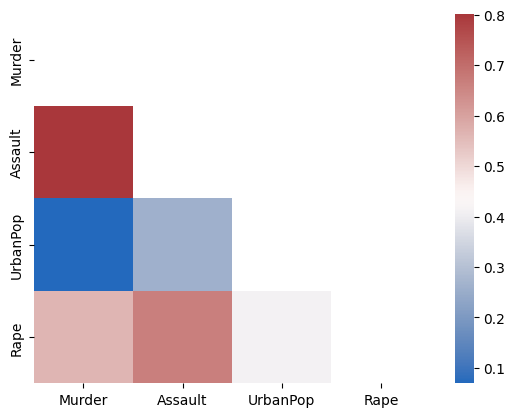

In [12]:
city = df.index
corr_df = df.corr()
labels =corr_df.columns

correlations = corr_df.corr()

import seaborn as sns
mask_ut=np.triu(np.ones(corr_df.shape)).astype(np.bool_)
sns.heatmap(corr_df, mask=mask_ut, cmap="vlag")
plt.show()

#### PCA
The PCA plot is now plotted, first without scaling to compare, then later on with scaling.


In [13]:
from sklearn.decomposition import PCA #run again if it does not converge the first time

np.set_printoptions(precision=2)

X = df.values.squeeze()

pca = PCA()

X_trans = pca.fit_transform(X)

df_pca = pd.DataFrame(X_trans)
df_pca.head()

,0,1,2,3
0,64.80,11.45,-2.49,2.41
1,92.83,17.98,20.13,-4.09
2,124.07,-8.83,-1.69,-4.35
3,18.34,16.70,0.21,-0.52
4,107.42,-22.52,6.75,-2.81


In [14]:
def biplot(score,coeff,labels=None,points=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())

    fig, ax = plt.subplots()    

    ax.scatter(xs * scalex,ys * scaley,s=5)

    for i in range(0,len(xs)):
        txt = city[i]
        ax.annotate(txt, (xs[i]* scalex, ys[i]* scaley))

    for i in range(n):
        ax.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            ax.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'green', ha = 'center', va = 'center')
        else:
            ax.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
 
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.grid()

    # Adapted from: https://ostwalprasad.github.io/machine-learning/PCA-using-python.html

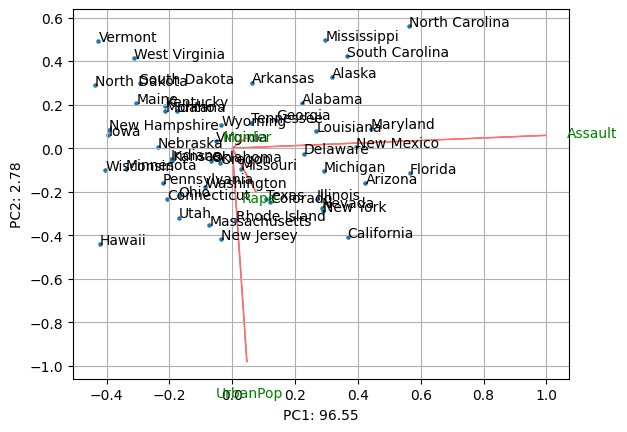

In [29]:
biplot(X_trans[:,0:2],np.transpose(pca.components_[0:2, :]),list(labels),list(df.index))
plt.xlabel("PC1: " + str(round(pca.explained_variance_ratio_[0]*100, 2)))
plt.ylabel("PC2: " + str(round(pca.explained_variance_ratio_[1]*100, 2)))
plt.show()

This is what the biplot looks like without scaling the data. Here, Assault strongly drives PC1 as it appears on the right hand side of the plot. However, as shown before in the boxplot, there is a large spread within this column and so may not be compared on the same scale as the other variables hence why scaling is performed below.

### Standardised data

We standardise the data so that some features do not swamp the others.

In [16]:
from sklearn.preprocessing import StandardScaler
X_std = StandardScaler().fit_transform(X)

std_pca = PCA()
X_std_trans = std_pca.fit_transform(X_std)

df_std_pca = pd.DataFrame(X_std_trans)
df_std_pca.head()

,0,1,2,3
0,0.99,1.13,-0.44,0.16
1,1.95,1.07,2.04,-0.44
2,1.76,-0.75,0.05,-0.83
3,-0.14,1.12,0.11,-0.18
4,2.52,-1.54,0.60,-0.34


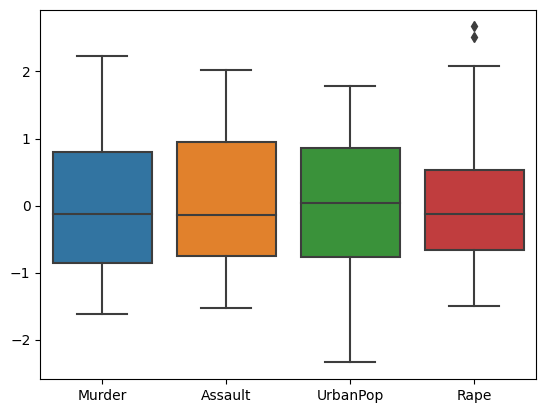

In [17]:
sns.boxplot(X_std)
plt.xticks([0,1,2,3],['Murder', 'Assault', 'UrbanPop', 'Rape'])
plt.show()

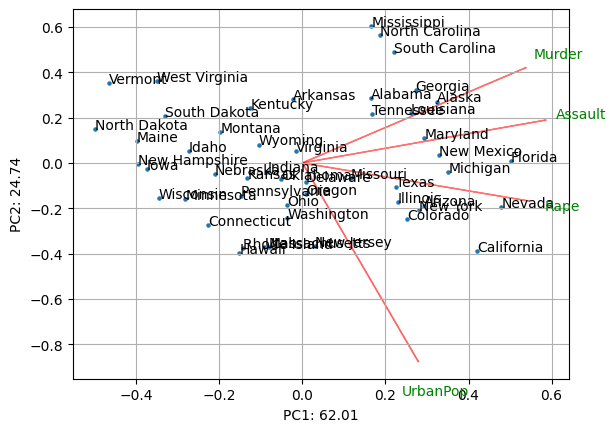

In [28]:
biplot(X_std_trans[:,0:2],np.transpose(std_pca.components_[0:2, :]),list(labels))
plt.xlabel("PC1: " + str(round(std_pca.explained_variance_ratio_[0]*100, 2)))
plt.ylabel("PC2: " + str(round(std_pca.explained_variance_ratio_[1]*100, 2)))

plt.show()

In [27]:
std_pca.explained_variance_ratio_

array([0.62, 0.25, 0.09, 0.04])

This shows the explained variance per principal component (in this case, 4). As a percentage, PC1 and PC2 explains 62% and 25% of the variance respectively, however, PC3 and PC4 only explains 9% and 4%. This means moving forward, PC1 and PC2 is enough.

We see that the standardised data results in far more variables being utilised to explain the variance, as the large numbers no longer dominate it.

<br> Here, 86% of the variance is explained by the first two principal components which is quite good. 

<br> Interestingly, North Dakota and Vermont is on the left hand side of PC1 and on the opposite end of the features indicating less association to murder, assault and rape. These can be termed as safer states as initially discussed using the bar plot.

In [ ]:
# Feature importance
pd.set_option('display.float_format', lambda x: '%.3f' % x) #change precision to see more decimal places

pc1 = abs( pca.components_[0] ) #components x features - access at index 0 to get the first component
pc2 = abs( pca.components_[1] )

feat_df = pd.DataFrame()
feat_df["Features"] = list(labels)
feat_df["PC1 Importance"] = pc1
feat_df["PC2 Importance"] = pc2
feat_df

,Features,PC1 Importance,PC2 Importance
0,Murder,0.042,0.045
1,Assault,0.995,0.059
2,UrbanPop,0.046,0.977
3,Rape,0.075,0.201


In [38]:
# Feature importance

pc1 = abs( std_pca.components_[0] ) #components x features - access at index 0 to get the first component
pc2 = abs( std_pca.components_[1] )

feat_df = pd.DataFrame()
feat_df["Features"] = list(labels)
feat_df["PC1 Importance"] = pc1
feat_df["PC2 Importance"] = pc2
feat_df

,Features,PC1 Importance,PC2 Importance
0,Murder,0.536,0.418
1,Assault,0.583,0.188
2,UrbanPop,0.278,0.873
3,Rape,0.543,0.167


Comparing the feature importance, we see the effects of scaling.

<br> For the unscaled components, Assault is the main driver by far compare to the other variables on PC1 and Urban population on PC2. As the features are scaled, the differences are less polar and can be compared within the same scale hence why it is important to scale the data and check for outliers before running a PCA.

Text(0.5, 1.0, 'Cumulative Explained Variance')

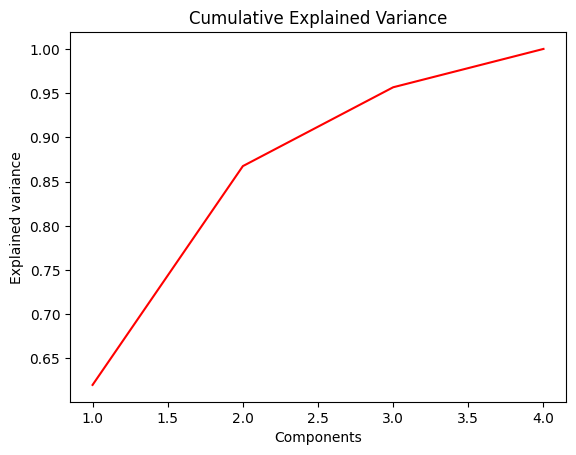

In [30]:
# Cumulative variance plot
plt.ylabel('Explained variance')
plt.xlabel('Components')
plt.plot(range(1,len(std_pca.explained_variance_ratio_ )+1),
         np.cumsum(std_pca.explained_variance_ratio_),
         c='red')
plt.title("Cumulative Explained Variance")

Using the cumulative explained variance, the first 3 principal components explain 96% of the variance.

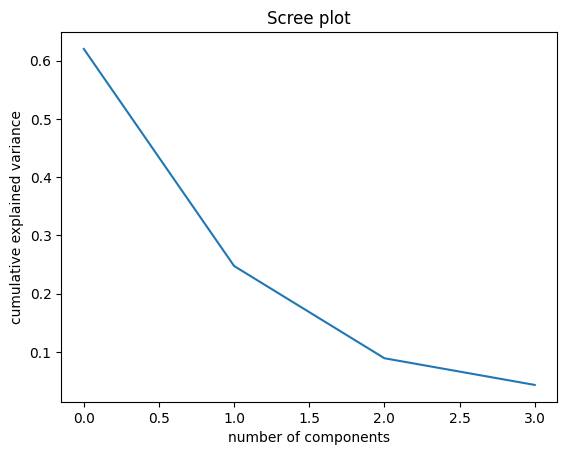

In [31]:
# Scree plot
plt.plot(std_pca.explained_variance_ratio_)
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.title("Scree plot")
plt.show()

The scree plot also show a similar pattern where the explained variance decreases as the number of components increase. In this case, it is 3 components.

The first 3 principal components together explain around 90% of the variance. We can therefore use them to perform cluster analysis. This is what we refer to as dimensionality reduction. We began with 4 variables and now we have 3 variables explaining most of the variability. 
This is not surprising given the small dataset.

<br>In this case, the scaled data is used moving forward.


In [32]:
pca_df = pd.DataFrame(X_std_trans[:,0:3], index = df.index)
pca_df.head()

,0,1,2
City,,,
Alabama,0.99,1.13,-0.44
Alaska,1.95,1.07,2.04
Arizona,1.76,-0.75,0.05
Arkansas,-0.14,1.12,0.11
California,2.52,-1.54,0.60


# Hierarchical clustering


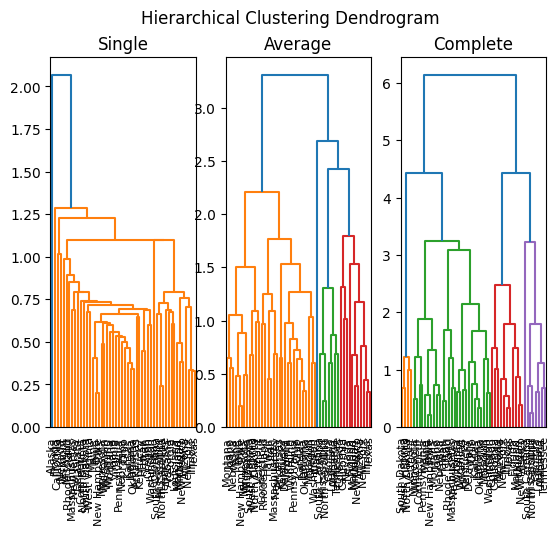

In [33]:
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering

model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model = model.fit(pca_df)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.suptitle('Hierarchical Clustering Dendrogram')
ax1.set_title("Single")
dendrogram(linkage(pca_df, method='single'), labels=pca_df.index, ax=ax1) #change method: eg. single, average, complete...
ax2.set_title("Average")
dendrogram(linkage(pca_df, method='average'), labels=pca_df.index, ax=ax2)
ax3.set_title("Complete")
dendrogram(linkage(pca_df, method='complete'), labels=pca_df.index, ax=ax3)
plt.show()

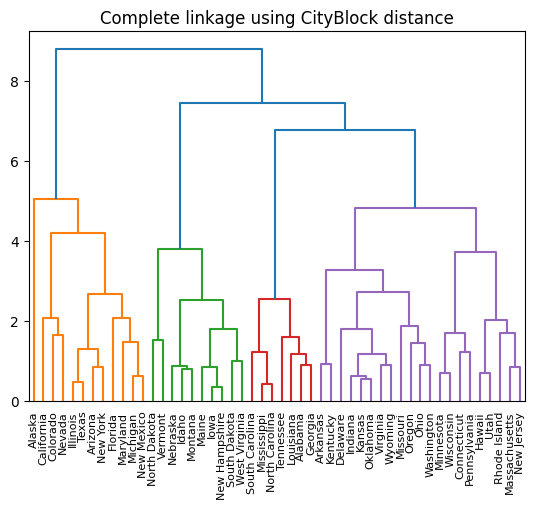

In [37]:
# Based on the graphs, the complete linkage is used moving forward together with cityblock as the metric.

plt.title("Complete linkage using CityBlock distance")
dendrogram(linkage(pca_df, method='complete', metric = "cityblock"), labels=pca_df.index)
plt.show()

By selecting these metrics to plot the dendrogram, we can see 4 clear clusters. 
Comparing it to the biplot below, we can see some similarties such as:
- Murder is associated with North and South Carolina, Mississippi and Georgia. These states are also clustered together in the dendrogram (red).
- 'Safer' states are grouped on the negative side of PC1 which are North Dakota, Maine, Vermont and West Virginia. These are also grouped together in the hierarchical cluster above in green.

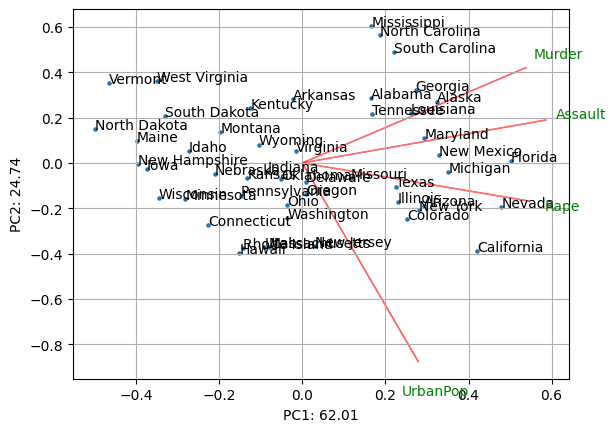

### K-means clustering

K-means is a very popular clustering partitioning algorithm that is fast and efficient and scales well for large datasets. It is an iterative process, so observations can switch between clusters while the algorithm runs until it converges at a local optimum. This method is not robust when it comes to noise data and outliers and is not suitable for clusters with non-convex shapes. Another drawback with K-means is the necessity of specifying K in advance.

For our analysis, it seems that the shape of clusters is likely to be regular based on the PCA biplot. K will be set to 4. A visualisation of the clusters is shown in the figure below.


C:\Users\shini\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


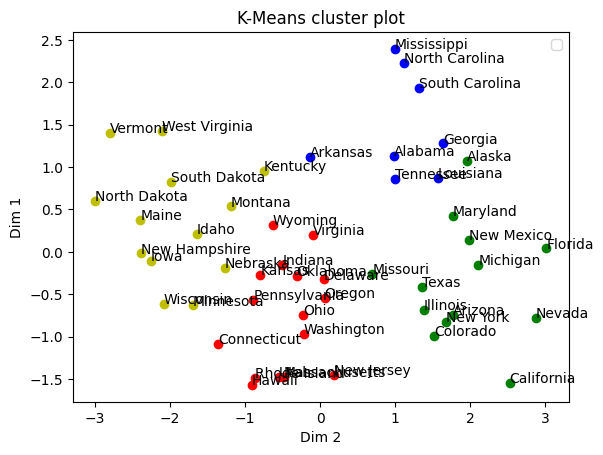

In [47]:
from sklearn.cluster import KMeans

# We extract the first two components
x = X_std_trans[:,0]
y = X_std_trans[:,1]

# Fit k-means
k=4
kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
cluster_labels = kmeans.fit_predict(pca_df)
cent = kmeans.cluster_centers_

# Plot clusters
fig, ax = plt.subplots()
colours = 'rbgy'
for i in range(0,k):
    ax.scatter(x[cluster_labels == i],y[cluster_labels == i],c = colours[i]) 

for i in range(0,len(x)):
        txt = city[i]
        ax.annotate(txt, (x[i], y[i]))
    
ax.set_title("K-Means cluster plot")
ax.set_xlabel("Dim 2")
ax.set_ylabel("Dim 1")
ax.legend()


In [44]:
from sklearn.metrics import accuracy_score, silhouette_score

score = round(silhouette_score(X, kmeans.labels_, metric='cityblock'),2)
print(score)

0.27


It looks like the silhouette score for the current dataset is only 0.27. To interpret what the silhouette score means. As the score approaches 1, the clusters are dense and well-separated from the other clusters. At 0, there are overlapping clusters with the samples very close to the decision boundary of the neighbouring clusters. Lastly, a negative score from -1 to 0, means that the samples may have been assigned to the wrong clusters.

<br> In this case, although there is some separation, quite a bit of overlap can be seen especially as the clusters are quite close together.

In [42]:
# Groups from K-means cluster- translate to readable names
clusters = pd.DataFrame()

group0_indices = np.argwhere(cluster_labels==0).transpose()[0]
group1_indices = np.argwhere(cluster_labels==1).transpose()[0]
group2_indices = np.argwhere(cluster_labels==2).transpose()[0]
group3_indices = np.argwhere(cluster_labels==3).transpose()[0]


group0 = np.array(city)[group0_indices]
group1 = np.array(city)[group1_indices]
group2 = np.array(city)[group2_indices]
group3 = np.array(city)[group3_indices]



print("Group 0: {}\n\n".format(group0))
print("Group 1: {}\n\n".format(group1))
print("Group 2: {}\n\n".format(group2))
print("Group 3: {}\n\n".format(group3))


Group 0: ['Connecticut' 'Delaware' 'Hawaii' 'Indiana' 'Kansas' 'Massachusetts'
 'New Jersey' 'Ohio' 'Oklahoma' 'Oregon' 'Pennsylvania' 'Rhode Island'
 'Utah' 'Virginia' 'Washington' 'Wyoming']


Group 1: ['Alabama' 'Arkansas' 'Georgia' 'Louisiana' 'Mississippi' 'North Carolina'
 'South Carolina' 'Tennessee']


Group 2: ['Alaska' 'Arizona' 'California' 'Colorado' 'Florida' 'Illinois'
 'Maryland' 'Michigan' 'Missouri' 'Nevada' 'New Mexico' 'New York' 'Texas']


Group 3: ['Idaho' 'Iowa' 'Kentucky' 'Maine' 'Minnesota' 'Montana' 'Nebraska'
 'New Hampshire' 'North Dakota' 'South Dakota' 'Vermont' 'West Virginia'
 'Wisconsin']





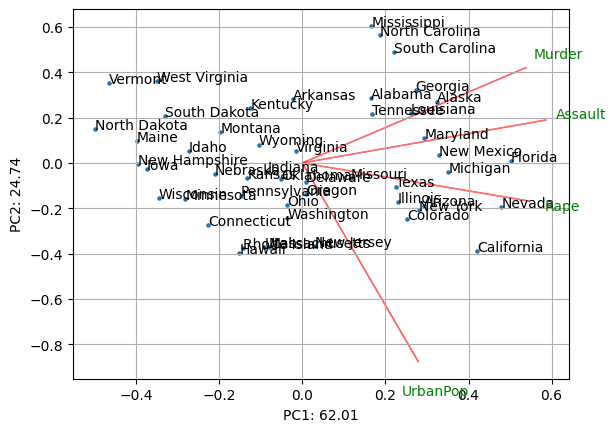
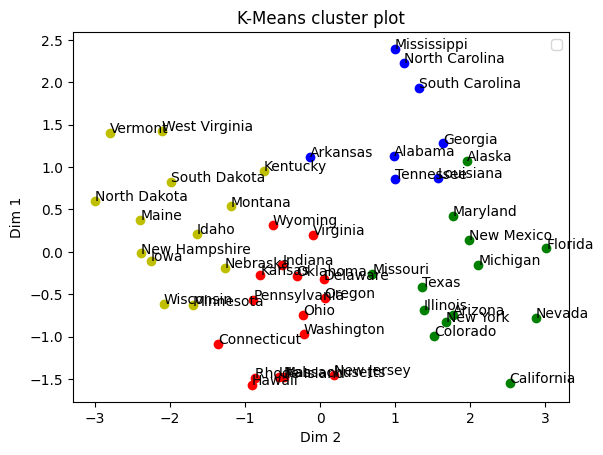
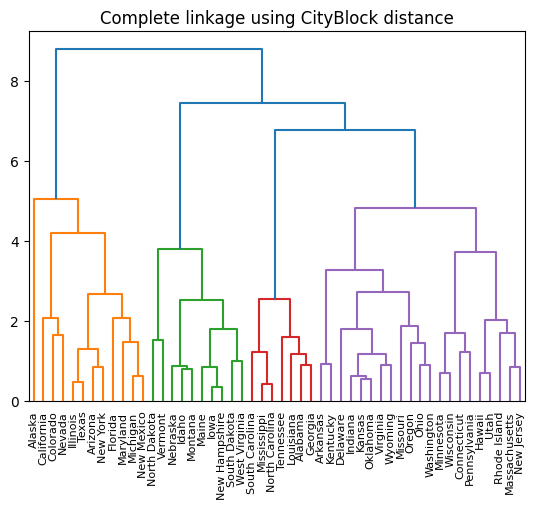

#### Summarising the data

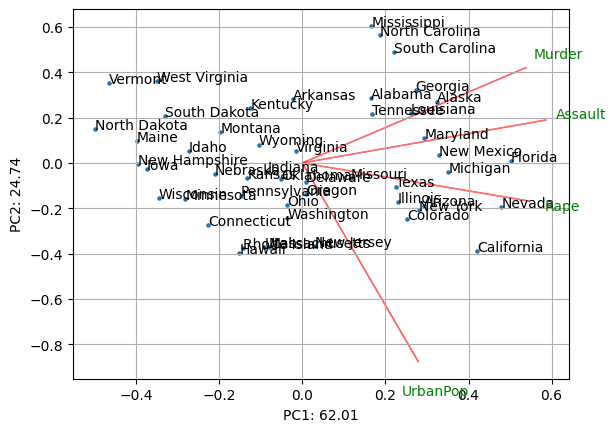
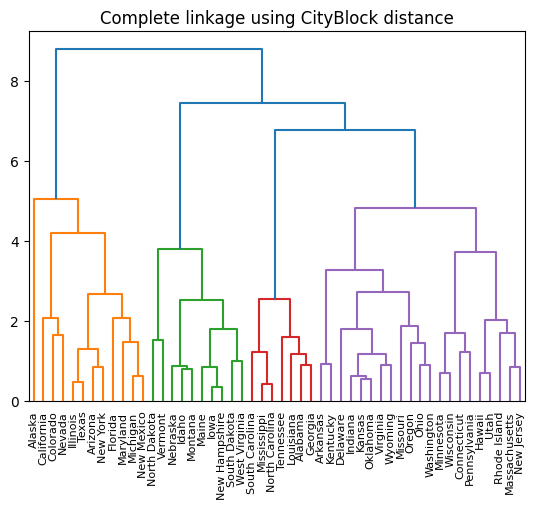
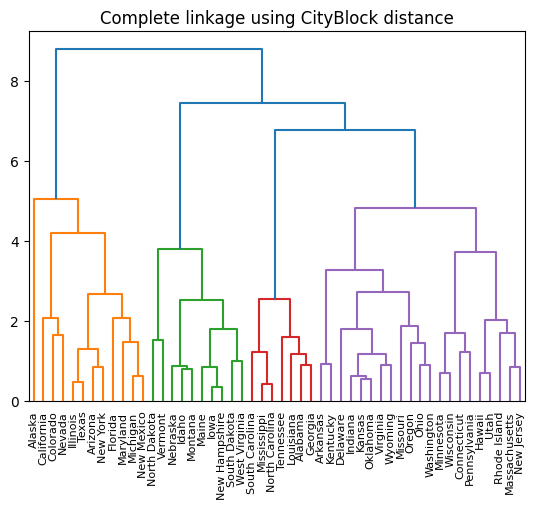
<br>It looks like the clustering/ grouping of the PCA is more comparable to the K-means clustering as opposed to the hierarchical clustering plotted.
Nonetheless, the silhouette value from the K-means clustering is quite low. Indicating perhaps, this may not be the best method to cluster the data.<br>
Hierarchical clustering may provide clearer information with similar general trends when compared to both the PCA and K-means clustering.
